In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import d1_riskkit_3101 as d1

from datetime import datetime
%matplotlib inline

# Importering og filtrering af data

 ### Data for aktier og obligationer

In [2]:
d1_data = pd.read_excel("Data/bondsandstocks_data.xlsx",
                      header=0, index_col=0, parse_dates=True)
d1_data = d1_data['1973-01-31':'2020-12-31']

In [3]:
# Her sættes værdi lig sidste business dag i måneden
mnd_data = d1_data.resample('BMS').last()

In [4]:
mnd_afkast = mnd_data.pct_change().dropna()

In [5]:
# Her ændres datoformat til år og måned
mnd_afkast.index = mnd_afkast.index.to_period('M')

In [6]:
mnd_afkast.columns = ['Obligationer', 'Aktier']

## Renter

### Risikofri rente 

In [7]:
rf_data= pd.read_excel("Data/risikofri_rente.xlsx",
                      header=0, index_col=0, parse_dates=True)

In [8]:
rf_år = rf_data['1973-01-31':'2020-12-31']/100

In [9]:
rf_måned = (1+rf_år)**(1/12)-1

In [10]:
# Her sættes værdi lig sidste business dag i måneden
mnd_rf = rf_måned.resample('BMS').last()

In [11]:
# Her ændres datoformat til år og måned
mnd_rf.index = mnd_rf.index.to_period('M')

In [12]:
mnd_rf.columns = ['Risikofri Rente']
mnd_rf = mnd_rf['1973-02':]

### Lånerente: Fed funds

In [13]:
r_lån_data= pd.read_excel("Data/fed_funds.xlsx",
                      header=0, index_col=0, parse_dates=True)

In [14]:
r_lån_år = r_lån_data['1973-01-31':'2020-12-31']/100

In [15]:
r_lån_mnd = (1+r_lån_år)**(1/12)-1

In [16]:
# Her sættes værdi lig sidste business dag i måneden
mnd_lån = r_lån_mnd.resample('BMS').last()

In [17]:
# Her ændres datoformat til år og måned
mnd_lån.index = mnd_lån.index.to_period('M')

In [18]:
# Her navngives kolonner
mnd_lån.columns = ['Lånerente']
mnd_lån = mnd_lån['1973-02':]

# Konstruering af porteføljer

## Statiske porteføljer

### Aktie portefølje bestående af S&P500

In [19]:
pf_aktie = pd.DataFrame({'Aktier': mnd_afkast['Aktier']})

### Traditionel 60/40 portefølje

In [20]:
# Her antages det at der rebalanceres månedligt
pf_6040 = 0.6*mnd_afkast['Aktier'] + 0.4*mnd_afkast['Obligationer']

In [21]:
pf_6040 = pd.DataFrame({'60/40 portefølje': pf_6040})

## Risk Parity porteføljer

### Funktion til optimering af RP vægte

In [22]:
# --------------------- Opdateret ud fra Bai et al, formel (13) - med kovarianser som input
from scipy.optimize import minimize

# Funktion der finder de optimale Risk Parity vægte 
def optimale_rp_vægte(cov):
    """
    Denne funktion finder de optimale Risk Parity vægte, 
    givet en tidsserie med månedlige kovarianser.
    """  
    n_aktiver = cov.shape[1]
    date_index = cov.index.get_level_values(0)
    datoindex = []
    for date, cov_date in cov.groupby(date_index): 
        datoindex.append(date)
    optimale_rul_rp_vægte = pd.DataFrame(columns = ['Vægt obl.', 'Vægt akt.'], index=datoindex)
    
    # Her laves en DataFrame med værdier svarende til index nummer, så vi kan lokalisere 
    # værdien der skal bruges med .iloc. Dette bruges i for-loopet til at finde værdien dagen før, 
    # der skal indgå som gæt
    step = pd.DataFrame(columns = ['step'], index=datoindex)   
    step['step'] = np.arange(len(datoindex))   
    
    for date, cov_date in cov.groupby(date_index):
        if step['step'].loc[date] == 0:
            gæt = 1/ n_aktiver
        else:
            gæt = optimale_rul_rp_vægte.iloc[step.loc[date]-1]
        cov_mat = cov_date.reset_index('Date', drop=True).to_numpy()
        rp_vægte = target_risk_contributions(cov_mat, gæt)
        optimale_rul_rp_vægte.loc[date] = rp_vægte 
        
    return optimale_rul_rp_vægte

def target_risk_contributions(cov, gæt):
    """
    Returnerer de porteføljevægte, der sikrer at risikobudgettet for
    det enkelte aktiv er så tæt på risikobudget som muligt,
    givet en kovariansmatrice.
    gæt anvendes i funktionen msd_risk
    """
    n = cov.shape[1] # antal aktiver
    bounds = ((0.0, 1.0),) * n # Vægte skal ligge mellem 0 og 1
    beta=1 # Beta sættes lig 1, da vi har en long only portefølje
    # Begrænsning nedenfor, vægte skal summe til 1
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def msd_risk(weights, cov, beta=1):
        """
        Objective funktionen er her sat lig (13) i Bai et al
        """
        antal_aktiver = cov.shape[1]
        risiko_budget = 1/antal_aktiver 
        res = 0.5 * np.dot(np.dot(weights, cov), weights.T) - np.sum(risiko_budget * np.log(weights*beta))
        return res
    
    weights = minimize(msd_risk, gæt,
                       args=(cov, beta), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

### Kovariansmatrice

In [23]:
# Kovarians matrice med 5 års rullende vindue - til validering af risikobidrag
cov_rul = mnd_afkast.rolling(60).cov()
cov_rul.index.names = ['Date', 'Aktiv']
cov_test = cov_rul.iloc[120:] # Her fjernes de første 60 måneder, da de har NaN værdier

### Beregning af vægte i RP portefølje - ud fra optimizer

In [24]:
rp_ug_vægte = optimale_rp_vægte(cov_test)

<AxesSubplot:>

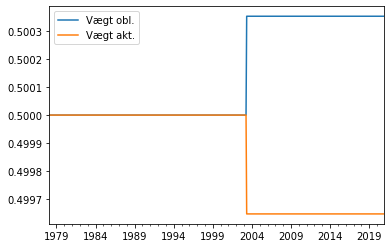

In [25]:
rp_ug_vægte.plot()

### Validering af vægte, ved beregning af risikobidrag

In [26]:
def risk_contribution(weights,cov):
    """
    Beregner risikobidrag i procent af den samlede portefølje volatilitet,
    givet vægte og en kovariansmatrice
    """
    total_portfolio_vol =  (weights.T @ cov @ weights)**0.5
    
    # Marginal contribution of each asset
    marginal_contrib = cov@weights
    
    # Risk contribution for each asset
    risk_contrib = np.multiply(marginal_contrib,weights.T)/total_portfolio_vol
    risk_contrib_pct = risk_contrib/total_portfolio_vol
    return risk_contrib_pct

def r_bidrag(w, cov):
    """
    Funktion der returnerer en DataFrame med det procentvise risikobidrag
    for hvert aktiv, givet tidsserier med vægte og kovariansmatricer
    """
    datoer = w.index
    n_steps = len(datoer)
    risiko_b = pd.DataFrame().reindex_like(w)
    risiko_b.columns = ['RB obl.', 'RB akt.']
    rb = 0
    for step in range(n_steps):
        # For cov ganges step med antal aktiver, for at få alle rækker i kovariansmatricen med
        rb = risk_contribution(w.iloc[step].ravel(), cov.iloc[step*2:step*2+2]) 
        risiko_b.iloc[step] = rb.ravel()      
    return risiko_b

In [27]:
risikobidrag = r_bidrag(rp_ug_vægte, cov_test)

<AxesSubplot:>

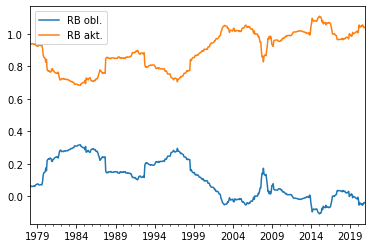

In [28]:
risikobidrag.plot()

## Naiv Risk Parity

In [29]:
std = mnd_afkast.rolling(60).std()[60:]
std_invers = (1/std)
invers = pd.DataFrame({'invers': std_invers.sum(axis=1)})
vægte_naiv_rp = std_invers.divide(invers['invers'], axis=0)
vægte_naiv_rp

,Obligationer,Aktier
Date,,
1978-02,0.833150,0.166850
1978-03,0.833777,0.166223
1978-04,0.836459,0.163541
1978-05,0.836188,0.163812
1978-06,0.835822,0.164178
...,...,...
2020-08,0.789498,0.210502
2020-09,0.790648,0.209352
2020-10,0.786283,0.213717


<AxesSubplot:xlabel='Date'>

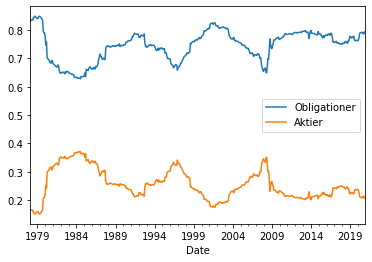

In [30]:
vægte_naiv_rp.plot()

In [31]:
risikobidrag_naiv_rp = r_bidrag(vægte_naiv_rp, cov_test)
risikobidrag_naiv_rp

,RB obl.,RB akt.
Date,,
1978-02,0.5,0.5
1978-03,0.5,0.5
1978-04,0.5,0.5
1978-05,0.5,0.5
1978-06,0.5,0.5
...,...,...
2020-08,0.5,0.5
2020-09,0.5,0.5
2020-10,0.5,0.5


# Naiv RP - ugearet afkast

In [32]:
afkast_aktiver = mnd_afkast['1978-02':]
afkast_naiv_rp_ug = vægte_naiv_rp.iloc[:,0] * afkast_aktiver.iloc[:,0]+vægte_naiv_rp.iloc[:,1] * afkast_aktiver.iloc[:,1]
afkast_naiv_rp_ug = pd.DataFrame({'Risk Parity Ugearet afkast': afkast_naiv_rp_ug})

# Gearing af naiv RP portefølje

$$ w_{a} * R_{p} + (1 - w_{a}) * r_{borrowing} $$

In [33]:
# Her samles RP ugearet og lånerente i en DataFrame
rp_aktiver = pd.DataFrame({'Risk Parity Ugearet afkast': afkast_naiv_rp_ug['Risk Parity Ugearet afkast'], 'Lånerente': mnd_lån['1978-02':'2020-12']['Lånerente']})

In [34]:
def objekt_funktion_gearet(ønsket_volatilitet, cov):
    
    n = cov.shape[0] # n is the number of assets
    init_guess = np.repeat(1/n, n) # Initial guess is 1/n per asset
    bounds = ((-5.0, 5.0),) * n # an N-tuple of 2-tuples!
    
    #Constraint
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights)-1
    }    
    
    # Objective function
    def objective(weights, ønsket_volatilitet, cov):
        portfolio_vol = np.dot(np.dot(weights.T, cov), weights)**0.5
        return ((portfolio_vol - ønsket_volatilitet)**2)
    
    weights = minimize(objective, init_guess, 
                       args=(ønsket_volatilitet, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,), 
                       bounds=bounds)
            
    return weights.x


def vægte_gearet_rp(samlet_afkast, ønsket_volatilitet):

    vægte = pd.DataFrame(index=samlet_afkast.index, columns=np.arange(2))
    vægte.columns = ['Vægt RP ugearet.', 'Vægt Lånerente']
    datoer = samlet_afkast.index
    n_steps = len(datoer)
    rp_g_vægte = 0
    
    for step in range(n_steps):
        if step >= 60:
            cov_rul = samlet_afkast.iloc[step-60:step].cov()*12
            rp_g_vægte = objekt_funktion_gearet(ønsket_volatilitet, cov_rul)
        
        vægte.iloc[step] = rp_g_vægte      
        
    return vægte.iloc[60:n_steps]

In [35]:
vægte_rp_g = vægte_gearet_rp(rp_aktiver, 0.1)

In [36]:
vægte_rp_g

,Vægt RP ugearet.,Vægt Lånerente
1983-02,1.16706,-0.167059
1983-03,1.16466,-0.164658
1983-04,1.16461,-0.164615
1983-05,1.14895,-0.148948
1983-06,1.13753,-0.137533
...,...,...
2020-08,2.91953,-1.91953
2020-09,3.00025,-2.00025
2020-10,2.96831,-1.96831
2020-11,2.92493,-1.92493


In [37]:
afkast_rp_g = vægte_rp_g.iloc[:,0] * rp_aktiver['1983-02':'2020-12'].iloc[:,0]+vægte_rp_g.iloc[:,1] * rp_aktiver['1983-02':'2020-12'].iloc[:,1]
afkast_rp_g = pd.DataFrame({'Risk Parity Gearet afkast': afkast_rp_g})

In [38]:
pf_afkast = pd.DataFrame({'Aktie portefølje': pf_aktie['Aktier']['1983-02':], '60/40 portefølje': pf_6040['60/40 portefølje']['1983-02':], 'Risk Parity Ugearet': afkast_naiv_rp_ug['Risk Parity Ugearet afkast']['1983-02':],'Risk Parity Gearet': afkast_rp_g['Risk Parity Gearet afkast']})

# Sammenligning af porteføljer

## Wealth index for samlet periode

In [39]:
wi = 1000*(1+pf_afkast).cumprod()

<AxesSubplot:>

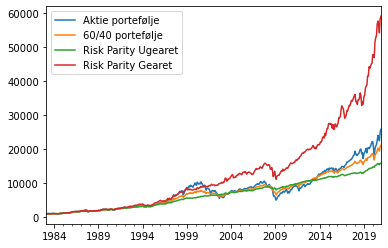

In [40]:
wi.plot()

## Portefølje statistik for samlet periode

In [41]:
risikofri_rente = np.array(mnd_rf['1983-02':])

In [42]:
d1.stats(pf_afkast, risikofri_rente)

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Aktie portefølje,0.089562,0.149760,0.233783,-0.525559
60/40 portefølje,0.083859,0.091108,0.325081,-0.319125
Risk Parity Ugearet,0.075762,0.051042,0.429501,-0.102858
Risk Parity Gearet,0.113548,0.099060,0.584436,-0.297732


## Performance under kriser
Ref til https://www.nber.org/research/data/us-business-cycle-expansions-and-contractions

OBS: Det er artiklen 'Fact and fiction about low risk investing' fra The Journal of Portfolio management' vi har brugt som udgangspunkt for periodeafgrænsning

In [43]:
# Fact and fiction perioder
p_1987_1987 = pf_afkast['1987-08':'1987-11']
p_2000_2002 = pf_afkast['2000-08':'2002-09']
p_2007_2009 = pf_afkast['2007-10':'2009-02']
p_2020_2020 = pf_afkast['2020-01':'2020-03']

In [44]:
# Beregning af akkumulerede afkast
ak_1987_1987 = (1+p_1987_1987).prod()-1
ak_2000_2002 = (1+p_2000_2002).prod()-1
ak_2007_2009 = (1+p_2007_2009).prod()-1
ak_2020_2020 = (1+p_2020_2020).prod()-1

In [45]:
tabel = pd.DataFrame({ '1987-08 til 1987-11': ak_1987_1987, '2000-08 til 2002-09': ak_2000_2002, '2007-10 til 2009-02': ak_2007_2009, '2020-01 til 2020-03': ak_2020_2020})
tabel.index.names = ['Akkumuleret afkast']
tabel

,1987-08 til 1987-11,2000-08 til 2002-09,2007-10 til 2009-02,2020-01 til 2020-03
Akkumuleret afkast,,,,
Aktie portefølje,-0.277286,-0.430205,-0.518526,-0.200011
60/40 portefølje,-0.162033,-0.203972,-0.310928,-0.092923
Risk Parity Ugearet,-0.060572,0.101917,-0.088788,0.013323
Risk Parity Gearet,-0.088275,0.125721,-0.276982,0.036155


## Risikobidrag for 60/40

In [46]:
vægte_60_40 = pd.DataFrame(columns = ['Vægt obl.', 'Vægt akt.'], index=pf_6040.index)
vægte_60_40[['Vægt obl.', 'Vægt akt.']] = [0.4, 0.6]
vægte_60_40 = vægte_60_40['1983-02':]

In [47]:
risikobidrag_60_40 = r_bidrag(vægte_60_40, cov_test['1983-02':])
risikobidrag_60_40

,RB obl.,RB akt.
Date,,
1983-02,0.184103,0.815897
1983-03,0.183517,0.816483
1983-04,0.188949,0.811051
1983-05,0.190119,0.809881
1983-06,0.189104,0.810896
...,...,...
2020-08,-0.053400,1.053400
2020-09,-0.050642,1.050642
2020-10,-0.044709,1.044709


In [48]:
risikobidrag_60_40.mean(axis=0)

RB obl.    0.048072
RB akt.    0.951928
dtype: float64

In [49]:
risikobidrag_60_40.max(axis=0)

RB obl.    0.207313
RB akt.    1.086661
dtype: float64

In [50]:
risikobidrag_60_40.min(axis=0)

RB obl.   -0.086661
RB akt.    0.792687
dtype: float64

<AxesSubplot:xlabel='Date'>

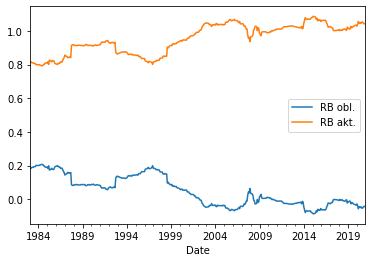

In [51]:
risikobidrag_60_40.plot()

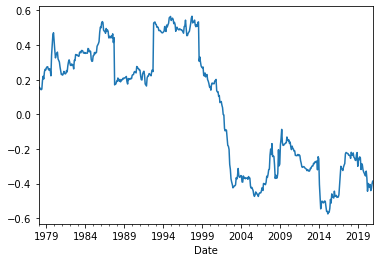

In [52]:
akt_obl_cov = mnd_afkast['Aktier'].rolling(60).corr(mnd_afkast['Obligationer']).dropna().plot()

### Herfindahl index

<AxesSubplot:xlabel='Date'>

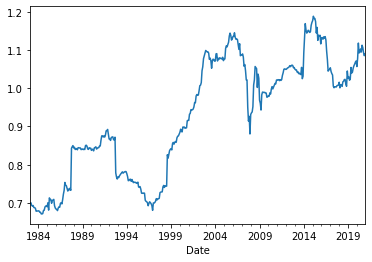

In [53]:
HI_6040 = (risikobidrag_60_40**2).sum(axis=1)
HI_6040.plot()

In [54]:
HI_naiv = (risikobidrag_naiv_rp**2).sum(axis=1)
HI_naiv

Date
1978-02    0.5
1978-03    0.5
1978-04    0.5
1978-05    0.5
1978-06    0.5
          ... 
2020-08    0.5
2020-09    0.5
2020-10    0.5
2020-11    0.5
2020-12    0.5
Freq: M, Length: 515, dtype: float64